## Access Maps for Uruguay

Calculate population-weigthed average travel time.
#### Inputs:
- Population raster
- Raster of min travel time to destinations
- Admin boundaries

In [151]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

In [152]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import rasterio as rio
from rasterstats import zonal_stats
from rasterio.plot import show
import matplotlib.colors as colors
from matplotlib import pyplot

In [154]:
data_path = '/home/public/Data/PROJECTS/infraSAP_URY'
raster_path = os.path.join(data_path, 'origins', 'ury_ppp_2020_UNadj_agg6.tif')
output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/weighted')
tt_path = '/home/wb514197/data/uruguay/travel_time_k5'
admin_path = '/home/wb514197/data/uruguay/admin/gadm36_URY_2.shp'

In [7]:
pop = rio.open(raster_path)

In [42]:
pop_trans = pop.transform

In [19]:
pop_arr = pop.read(1, masked=True)

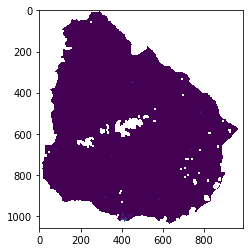

In [23]:
show(pop_arr)

In [167]:
districts = gpd.read_file(admin_path).to_crs('epsg:32721')

In [168]:
pop.nodata

-3.4028234663852886e+38

In [169]:
pop_trans

Affine(520.1771570498263, 0.0, 360937.85609559854,
       0.0, -520.1771570498263, 6672569.543746284)

In [170]:
zs_sum = pd.DataFrame(zonal_stats(districts, pop_arr, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'total_pop'})

In [171]:
districts = districts.join(zs_sum)

In [173]:
from GOSTnets.conversion_utils import rasterize_od_results

In [174]:
rasterize_od_results(districts, os.path.join(output_path,"pop_sum.tif"),'total_pop', template=raster_path)

In [175]:
pop_sum = rio.open(os.path.join(output_path,"pop_sum.tif"))

In [176]:
pop_sum_arr = pop_sum.read(1)

In [179]:
pop_sum_arr[pop_sum_arr==-99] = np.nan

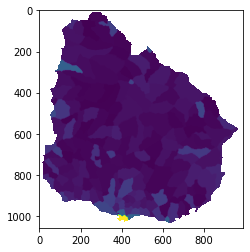

In [181]:
show(pop_sum_arr, norm=colors.PowerNorm(gamma=0.5))

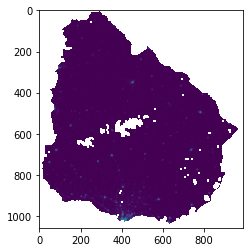

In [182]:
show(pop_arr, norm=colors.PowerNorm(gamma=0.5))

In [183]:
weights = pop_arr/pop_sum_arr

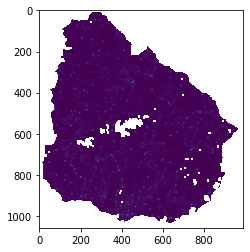

In [184]:
show(weights, norm=colors.PowerNorm(gamma=0.5))

In [190]:
zs_sum_weights = pd.DataFrame(zonal_stats(districts, weights, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'sum_weights'})

In [193]:
zs_sum_weights.min()

sum_weights    1.0
dtype: float64

In [185]:
tt_cities = rio.open(os.path.join(tt_path, 'cities_min_tt.tif')).read(1)
tt_borders = rio.open(os.path.join(tt_path, 'borders_min_tt.tif')).read(1)
tt_airport = rio.open(os.path.join(tt_path, 'airport_min_tt.tif')).read(1)
tt_port = rio.open(os.path.join(tt_path, 'port_min_tt.tif')).read(1)

In [186]:
tt_cities_weighted = tt_cities*weights
tt_borders_weighted = tt_borders*weights
tt_airport_weighted = tt_airport*weights
tt_port_weighted = tt_port*weights

In [187]:
zs_sum_tt_cities = pd.DataFrame(zonal_stats(districts, tt_cities_weighted, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'tt_cities_w'})
zs_sum_tt_borders = pd.DataFrame(zonal_stats(districts, tt_borders_weighted, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'tt_borders_w'})
zs_sum_tt_airports = pd.DataFrame(zonal_stats(districts, tt_airport_weighted, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'tt_airports_w'})
zs_sum_tt_ports = pd.DataFrame(zonal_stats(districts, tt_port_weighted, affine=pop_trans, stats='sum', nodata=-3.4028234663852886e+38)).rename(columns={'sum':'tt_ports_w'})

In [188]:
districts_results = districts.join([zs_sum_tt_cities, zs_sum_tt_borders, zs_sum_tt_airports, zs_sum_tt_ports])

In [189]:
districts_results.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,total_pop,tt_cities_w,tt_borders_w,tt_airports_w,tt_ports_w
0,URY,Uruguay,URY.1_1,Artigas,None,URY.1.1_1,n.a2,None,None,Población,Poblacion,None,None,"POLYGON ((502442.781 6642371.492, 502431.549 6...",284.702016,142.799890,143.736593,137.317815,427.369741
1,URY,Uruguay,URY.1_1,Artigas,None,URY.1.2_1,n.a3,None,None,Población,Poblacion,None,None,"POLYGON ((459878.431 6648606.963, 459780.918 6...",17591.391671,223.126068,14.274054,228.587883,225.895016
2,URY,Uruguay,URY.1_1,Artigas,None,URY.1.3_1,n.a4,None,None,Población,Poblacion,None,None,"POLYGON ((476807.359 6604569.212, 476521.637 6...",37.694051,185.642490,133.562770,180.361167,306.573400
3,URY,Uruguay,URY.1_1,Artigas,None,URY.1.4_1,n.a5,None,None,Población,Poblacion,None,None,"POLYGON ((470505.996 6610124.329, 470499.431 6...",2561.727076,227.221481,60.572292,221.814995,243.520383
4,URY,Uruguay,URY.1_1,Artigas,None,URY.1.5_1,n.a6,None,None,Población,Poblacion,None,None,"POLYGON ((559422.958 6626412.593, 559086.180 6...",44428.317189,5.005540,4.923003,9.832659,416.434128


In [194]:
districts_results.to_file(os.path.join(output_path,"URY_Admin2.shp"), driver='ESRI Shapefile')